In [105]:
import bayes3d as b
import os
import jax.numpy as jnp
import jax
import bayes3d.genjax
import genjax
import matplotlib
import matplotlib.pyplot as plt

In [58]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [2]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=500.0, fy=500.0,
    cx=50.0, cy=50.0,
    near=0.01, far=20.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [3]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 1.20]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

key = jax.random.PRNGKey(500)

importance_jit = jax.jit(b.genjax.model.importance)
update_jit = jax.jit(b.genjax.model.update)

In [4]:
b.utils.ycb_loader.MODEL_NAMES[13]

'025_mug'

In [18]:
single_enumerators = b.genjax.make_enumerator([f"contact_params_1"])

In [44]:
contact_enumerators = [b.genjax.make_enumerator([f"contact_params_{i}", "variance", "outlier_prob"]) for i in range(5)]

def c2f_contact_update(trace_, key,  number, contact_param_deltas, VARIANCE_GRID, OUTLIER_GRID):
    contact_param_grid = contact_param_deltas + trace_[f"contact_params_{number}"]
    scores = contact_enumerators[number][3](trace_, key, contact_param_grid, VARIANCE_GRID, OUTLIER_GRID)
    i,j,k = jnp.unravel_index(scores.argmax(), scores.shape)
    return contact_enumerators[number][0](
        trace_, key,
        contact_param_grid[i], VARIANCE_GRID[j], OUTLIER_GRID[k]
    )
c2f_contact_update_jit = jax.jit(c2f_contact_update, static_argnames=("number",))

In [137]:
VARIANCE_GRID = jnp.array([0.001])
OUTLIER_GRID = jnp.array([0.01])
OUTLIER_VOLUME = 100.0

grid_params = [
    (0.3, jnp.pi, (11,11,11)), (0.2, jnp.pi, (11,11,11)), (0.1, jnp.pi, (11,11,11)),
    (0.05, jnp.pi/3, (11,11,11)), (0.02, jnp.pi, (5,5,51)), (0.01, jnp.pi/5, (11,11,11)), (0.01, 0.0, (21,21,1)),(0.05, 0.0, (21,21,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

[624233589 966953376]


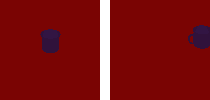

In [138]:
key = jax.random.split(key,1)[0]
print(key)
weight, trace = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "id_0": jnp.int32(21),
    "id_1": jnp.int32(13),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 2,
    "face_child_1": 3,
    "variance": VARIANCE_GRID[0],
    "outlier_prob": OUTLIER_GRID[0],
}), (
    jnp.arange(2),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
    b.RENDERER.model_box_dims, OUTLIER_VOLUME)
                              )
_, weight, trace, discard = update_jit(
    key,
    trace,
    genjax.choice_map({"contact_params_1": jnp.zeros(3)}),
    b.genjax.make_unknown_change_argdiffs(trace)
)

b.hstack_images([
    b.get_depth_image(b.genjax.get_rendered_image(trace)[...,2]),
    b.get_depth_image(trace["image"][...,2])
])

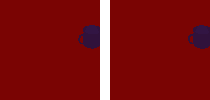

In [139]:
path = []
trace_ = trace
path.append(trace_)
number = 1
V_GRID = VARIANCE_GRID
O_GRID = OUTLIER_GRID
for c2f_iter in range(len(contact_param_gridding_schedule)):
    trace_ = c2f_contact_update_jit(trace_, key, number,
        contact_param_gridding_schedule[c2f_iter], V_GRID, O_GRID)
    path.append(trace_)
trace = trace_
b.hstack_images([
    b.get_depth_image(b.genjax.get_rendered_image(trace)[...,2]),
    b.get_depth_image(trace["image"][...,2])
])

[-0.18500002 -0.04799999  1.1627064 ]


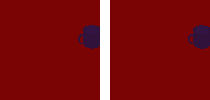

In [140]:
width = 0.01
ang = jnp.pi
contact_param_deltas = b.utils.make_translation_grid_enumeration_3d(
    -width, -width, -ang,
    width, width, ang,
    9,9,100
)
contact_param_grid = contact_param_deltas + trace_[f"contact_params_{number}"]
weights = single_enumerators[3](
    trace_,
    key,
    contact_param_grid,
)
print(contact_param_grid[weights.argmax()])
best_trace = single_enumerators[0](trace_, key, contact_param_grid[weights.argmax()])

# b.genjax.viz_trace_meshcat(best_trace)
b.hstack_images([
    b.get_depth_image(b.genjax.get_rendered_image(best_trace)[...,2]),
    b.get_depth_image(best_trace["image"][...,2])
])

In [141]:
print(jnp.sort(weights))
print(jnp.sort(b.utils.normalize_log_scores(weights)))
sampled_indices = jax.random.categorical(key, weights, shape=(100,))
print(sampled_indices)
print(weights[sampled_indices])

[55758.812 55763.484 55781.383 ... 57848.164 57852.75  57853.12 ]
[0.         0.         0.         ... 0.00410277 0.40246135 0.58329487]
[4051 4050 4051 4050 4051 4051 4050 4951 4050 4051 4050 4051 4050 4051
 4051 4050 4051 4050 4050 4050 4051 4050 4051 4051 4051 4051 4050 4050
 4050 4051 4051 4051 4051 4051 4050 4051 4050 4050 4050 4050 4051 4050
 4050 4050 4050 4050 4050 4050 4051 4050 4050 4051 4050 4051 4051 4050
 4050 4050 4051 4051 4050 4050 4051 4050 4050 4050 4051 4050 4051 4050
 4051 4050 4050 4050 4050 4051 4051 4050 4050 4050 4050 4050 4050 4051
 4050 4050 4050 4050 4051 4050 4050 4051 4050 4050 4050 4050 4051 4051
 4050 4051]
[57852.75  57853.12  57852.75  57853.12  57852.75  57852.75  57853.12
 57847.844 57853.12  57852.75  57853.12  57852.75  57853.12  57852.75
 57852.75  57853.12  57852.75  57853.12  57853.12  57853.12  57852.75
 57853.12  57852.75  57852.75  57852.75  57852.75  57853.12  57853.12
 57853.12  57852.75  57852.75  57852.75  57852.75  57852.75  57853.12
 57

In [142]:
sampled_params = contact_param_grid[sampled_indices]

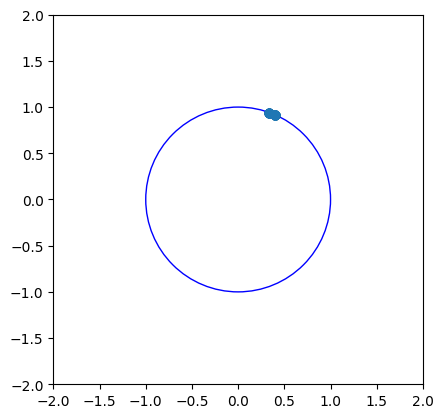

In [143]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
circ = plt.Circle((0, 0), radius=1, edgecolor='b', facecolor='None')
ax.add_patch(circ)
plt.xlim(-2.0, 2.0)
plt.ylim(-2.0, 2.0)
plt.scatter(jnp.cos(sampled_params[:,2]),jnp.sin(sampled_params[:,2]))
plt.show()

In [34]:
b.RENDERER.model_box_dims[13]

Array([0.116966, 0.093075, 0.081384], dtype=float32)